In [75]:
# Enable outputting results interactively. 
# All the results from code in a given cell will be displayed instead of only the last one.


In [115]:
#EDA and preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from pywaffle import Waffle
%matplotlib inline
%run 'src/EDA.py'

#time series predictions
from fbprophet import Prophet
import logging

In [33]:
df = pd.read_csv('data/boston15-19.csv')

In [34]:
df.head(3)

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,I192056106,562,Other Burglary,BURGLARY - OTHER - NO FORCE,C6,186,NaN,2019-07-20 21:49:00,2019,7,Saturday,21,Part One,MASSACHUSETTS AVE,42.325538,-71.065796,"(42.32553801, -71.06579592)"
1,I192056104,3115,Investigate Person,INVESTIGATE PERSON,C11,342,NaN,2019-07-20 20:07:00,2019,7,Saturday,20,Part Three,GENEVA AVE,42.301351,-71.067965,"(42.30135087, -71.06796465)"
2,I192056102,3301,Verbal Disputes,VERBAL DISPUTE,C11,373,NaN,2019-07-20 20:43:00,2019,7,Saturday,20,Part Three,SOUTHWICK ST,42.291436,-71.049098,"(42.29143617, -71.04909809)"


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405254 entries, 0 to 405253
Data columns (total 17 columns):
INCIDENT_NUMBER        405254 non-null object
OFFENSE_CODE           405254 non-null int64
OFFENSE_CODE_GROUP     405254 non-null object
OFFENSE_DESCRIPTION    405254 non-null object
DISTRICT               403111 non-null object
REPORTING_AREA         405254 non-null object
SHOOTING               1653 non-null object
OCCURRED_ON_DATE       405254 non-null object
YEAR                   405254 non-null int64
MONTH                  405254 non-null int64
DAY_OF_WEEK            405254 non-null object
HOUR                   405254 non-null int64
UCR_PART               405146 non-null object
STREET                 393213 non-null object
Lat                    379698 non-null float64
Long                   379698 non-null float64
Location               405254 non-null object
dtypes: float64(2), int64(4), object(11)
memory usage: 52.6+ MB


### Boston Crime Analysis

In [36]:
df['MONTH'].replace({1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}, inplace=True)

In [37]:
# extract date from OCCURRED ON DATE and create date column
df['date'] = df['OCCURRED_ON_DATE'].apply(lambda x: date_split(x))

In [38]:
# extract time from OCCURRED ON DATE and create time column
df['time'] = df['OCCURRED_ON_DATE'].apply(lambda x: time_split(x))

In [39]:
df[['date','time']].head(3)

,date,time
0,2019-07-20,21:49:00
1,2019-07-20,20:07:00
2,2019-07-20,20:43:00


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Counts of Incidents by Month')

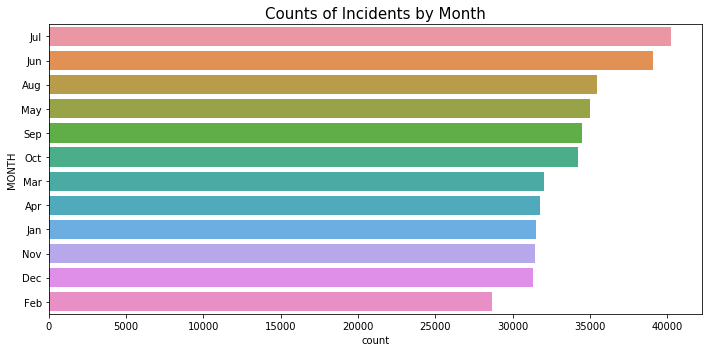

In [14]:
plt.figure(figsize = (10, 5))
sns.countplot(y= 'MONTH', data = df, order = df['MONTH'].value_counts().iloc[:12].index)
plt.title('Counts of Incidents by Month',size=15)
plt.tight_layout()
plt.savefig('img/incidents_month.png')

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Counts of Incidents by Weekday')

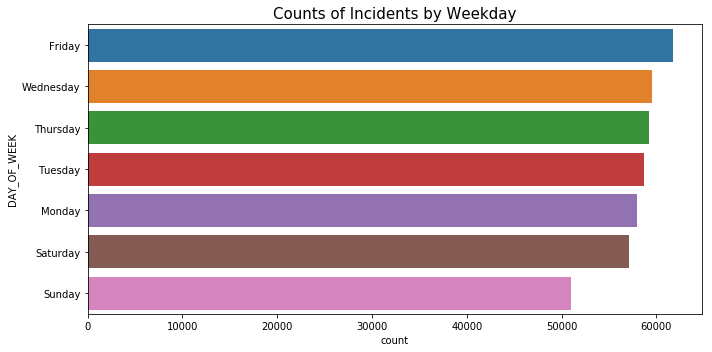

In [15]:
plt.figure(figsize = (10,5))
sns.countplot(y='DAY_OF_WEEK', data=df, order=df['DAY_OF_WEEK'].value_counts().iloc[:7].index)
plt.title('Counts of Incidents by Weekday',size=15)
plt.tight_layout()
plt.savefig('img/incidents_weekday.png')

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Counts of Incidents by Hour of Day')

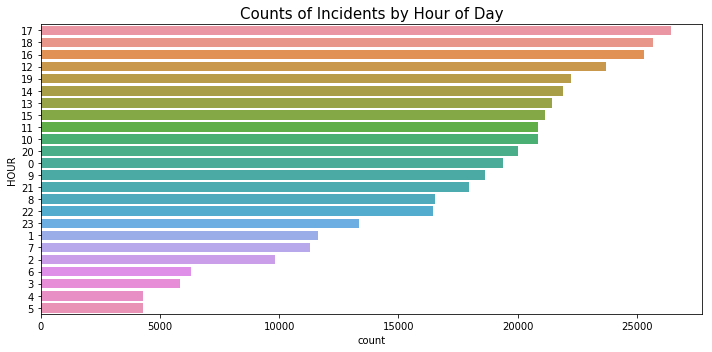

In [16]:
plt.figure(figsize = (10,5))
sns.countplot(y='HOUR', data=df, order=df['HOUR'].value_counts().iloc[:24].index)
plt.title('Counts of Incidents by Hour of Day',size=15)
plt.tight_layout()
plt.savefig('img/incidents_hour.png')

<Figure size 720x1296 with 0 Axes>

Text(0.5, 1.0, 'Counts of Incidents by Offense Code')

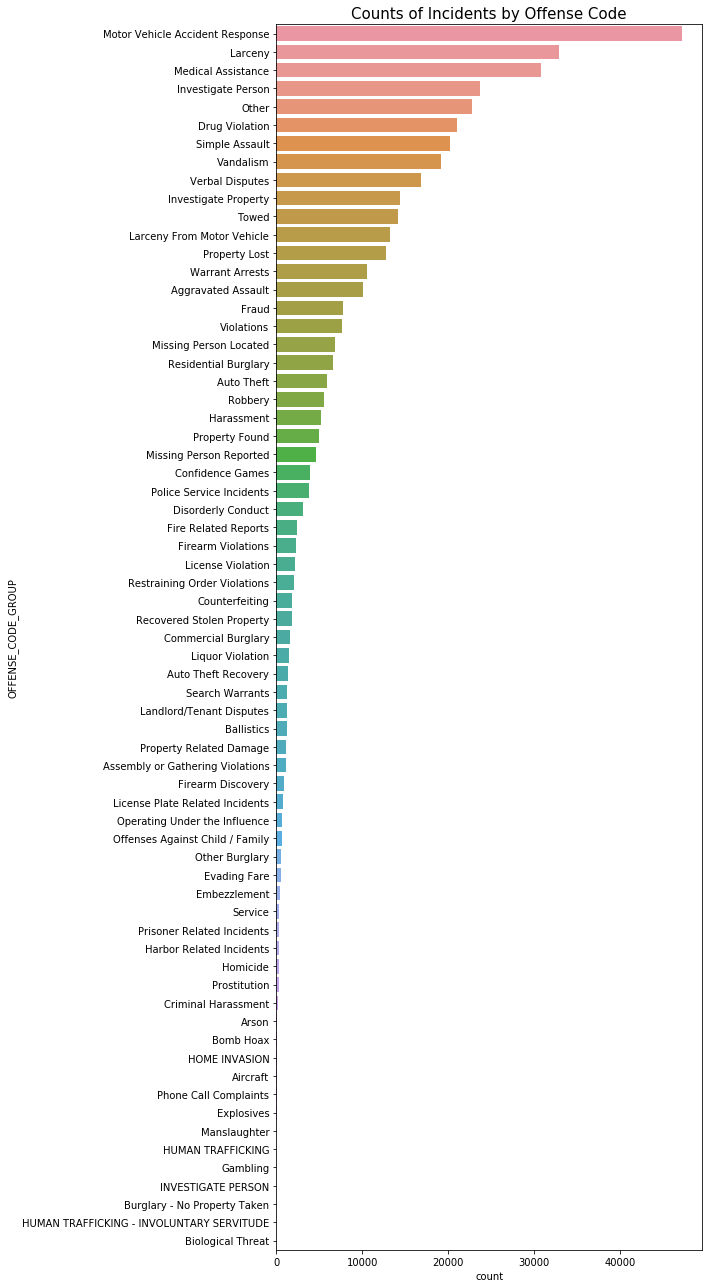

In [17]:
plt.figure(figsize = (10,18))
sns.countplot(y='OFFENSE_CODE_GROUP', data=df, order=df['OFFENSE_CODE_GROUP'].value_counts().iloc[:100].index)
plt.title('Counts of Incidents by Offense Code',size=15)
plt.tight_layout()
plt.savefig('img/incidents_offense_code.png')

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Counts of Incidents by UCR Part')

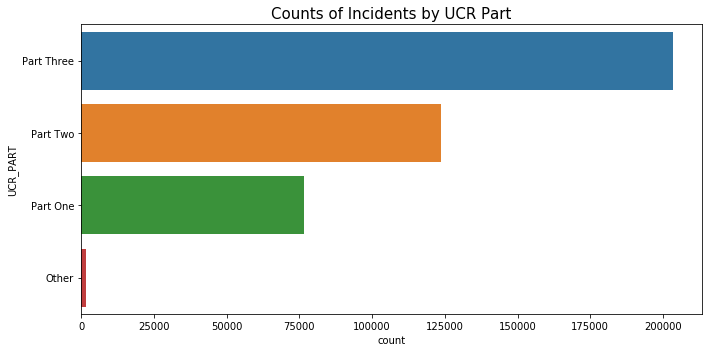

In [18]:
plt.figure(figsize = (10,5))
sns.countplot(y='UCR_PART', data=df, order=df['UCR_PART'].value_counts().iloc[:8].index)
plt.title('Counts of Incidents by UCR Part',size=15)
plt.tight_layout()
plt.savefig('img/incidents_UCR.png')

<Figure size 720x576 with 0 Axes>

Text(0.5, 1.0, 'Counts of Incidents by District')

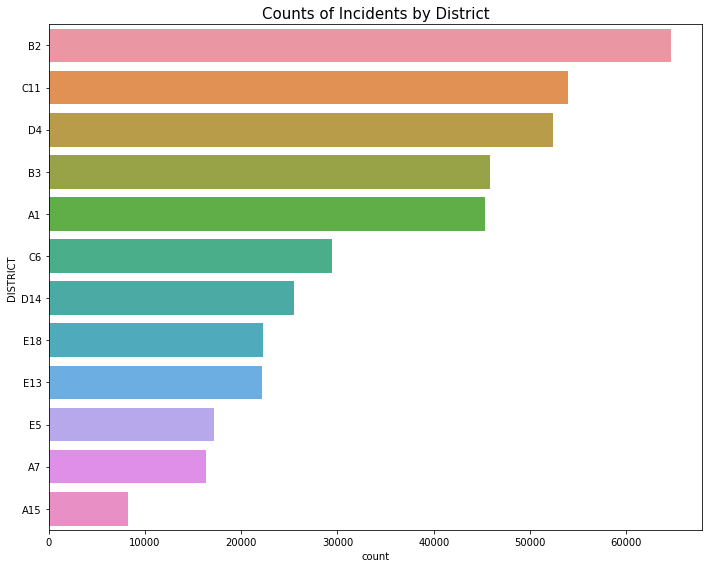

In [108]:
plt.figure(figsize=(10, 8))
sns.countplot(y='DISTRICT', data=df, order=df['DISTRICT'].value_counts().iloc[:].index)
plt.title('Counts of Incidents by District',size=15)
plt.tight_layout()
plt.savefig('img/incidents_district.png')

In [111]:
waffle = pd.DataFrame(df.DISTRICT.value_counts())
waffle.reset_index(inplace=True)

In [113]:
waffle.columns = ['district', 'count']
waffle

,district,count
0,B2,64639
1,C11,53959
2,D4,52383
3,B3,45802
4,A1,45274
5,C6,29477
6,D14,25442
7,E18,22236
8,E13,22129
9,E5,17172


In [125]:
# # waffledistrict
# fig = plt.figure(
#     FigureClass=Waffle,
#     rows=12,
#     values= list(waffle['count']),
#     labels= list(waffle['district']))


In [24]:
dailydf = df[['date', 'INCIDENT_NUMBER']].groupby('date').count()
dailydf.reset_index(inplace=True)
dailydf.columns = ['ds', 'y']

In [22]:
dailydf.head()

,date,count
0,2015-06-15,249
1,2015-06-16,258
2,2015-06-17,235
3,2015-06-18,294
4,2015-06-19,289


<Figure size 3600x1800 with 0 Axes>

/Users/claudiostaub/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Counts of Incidents by Day')

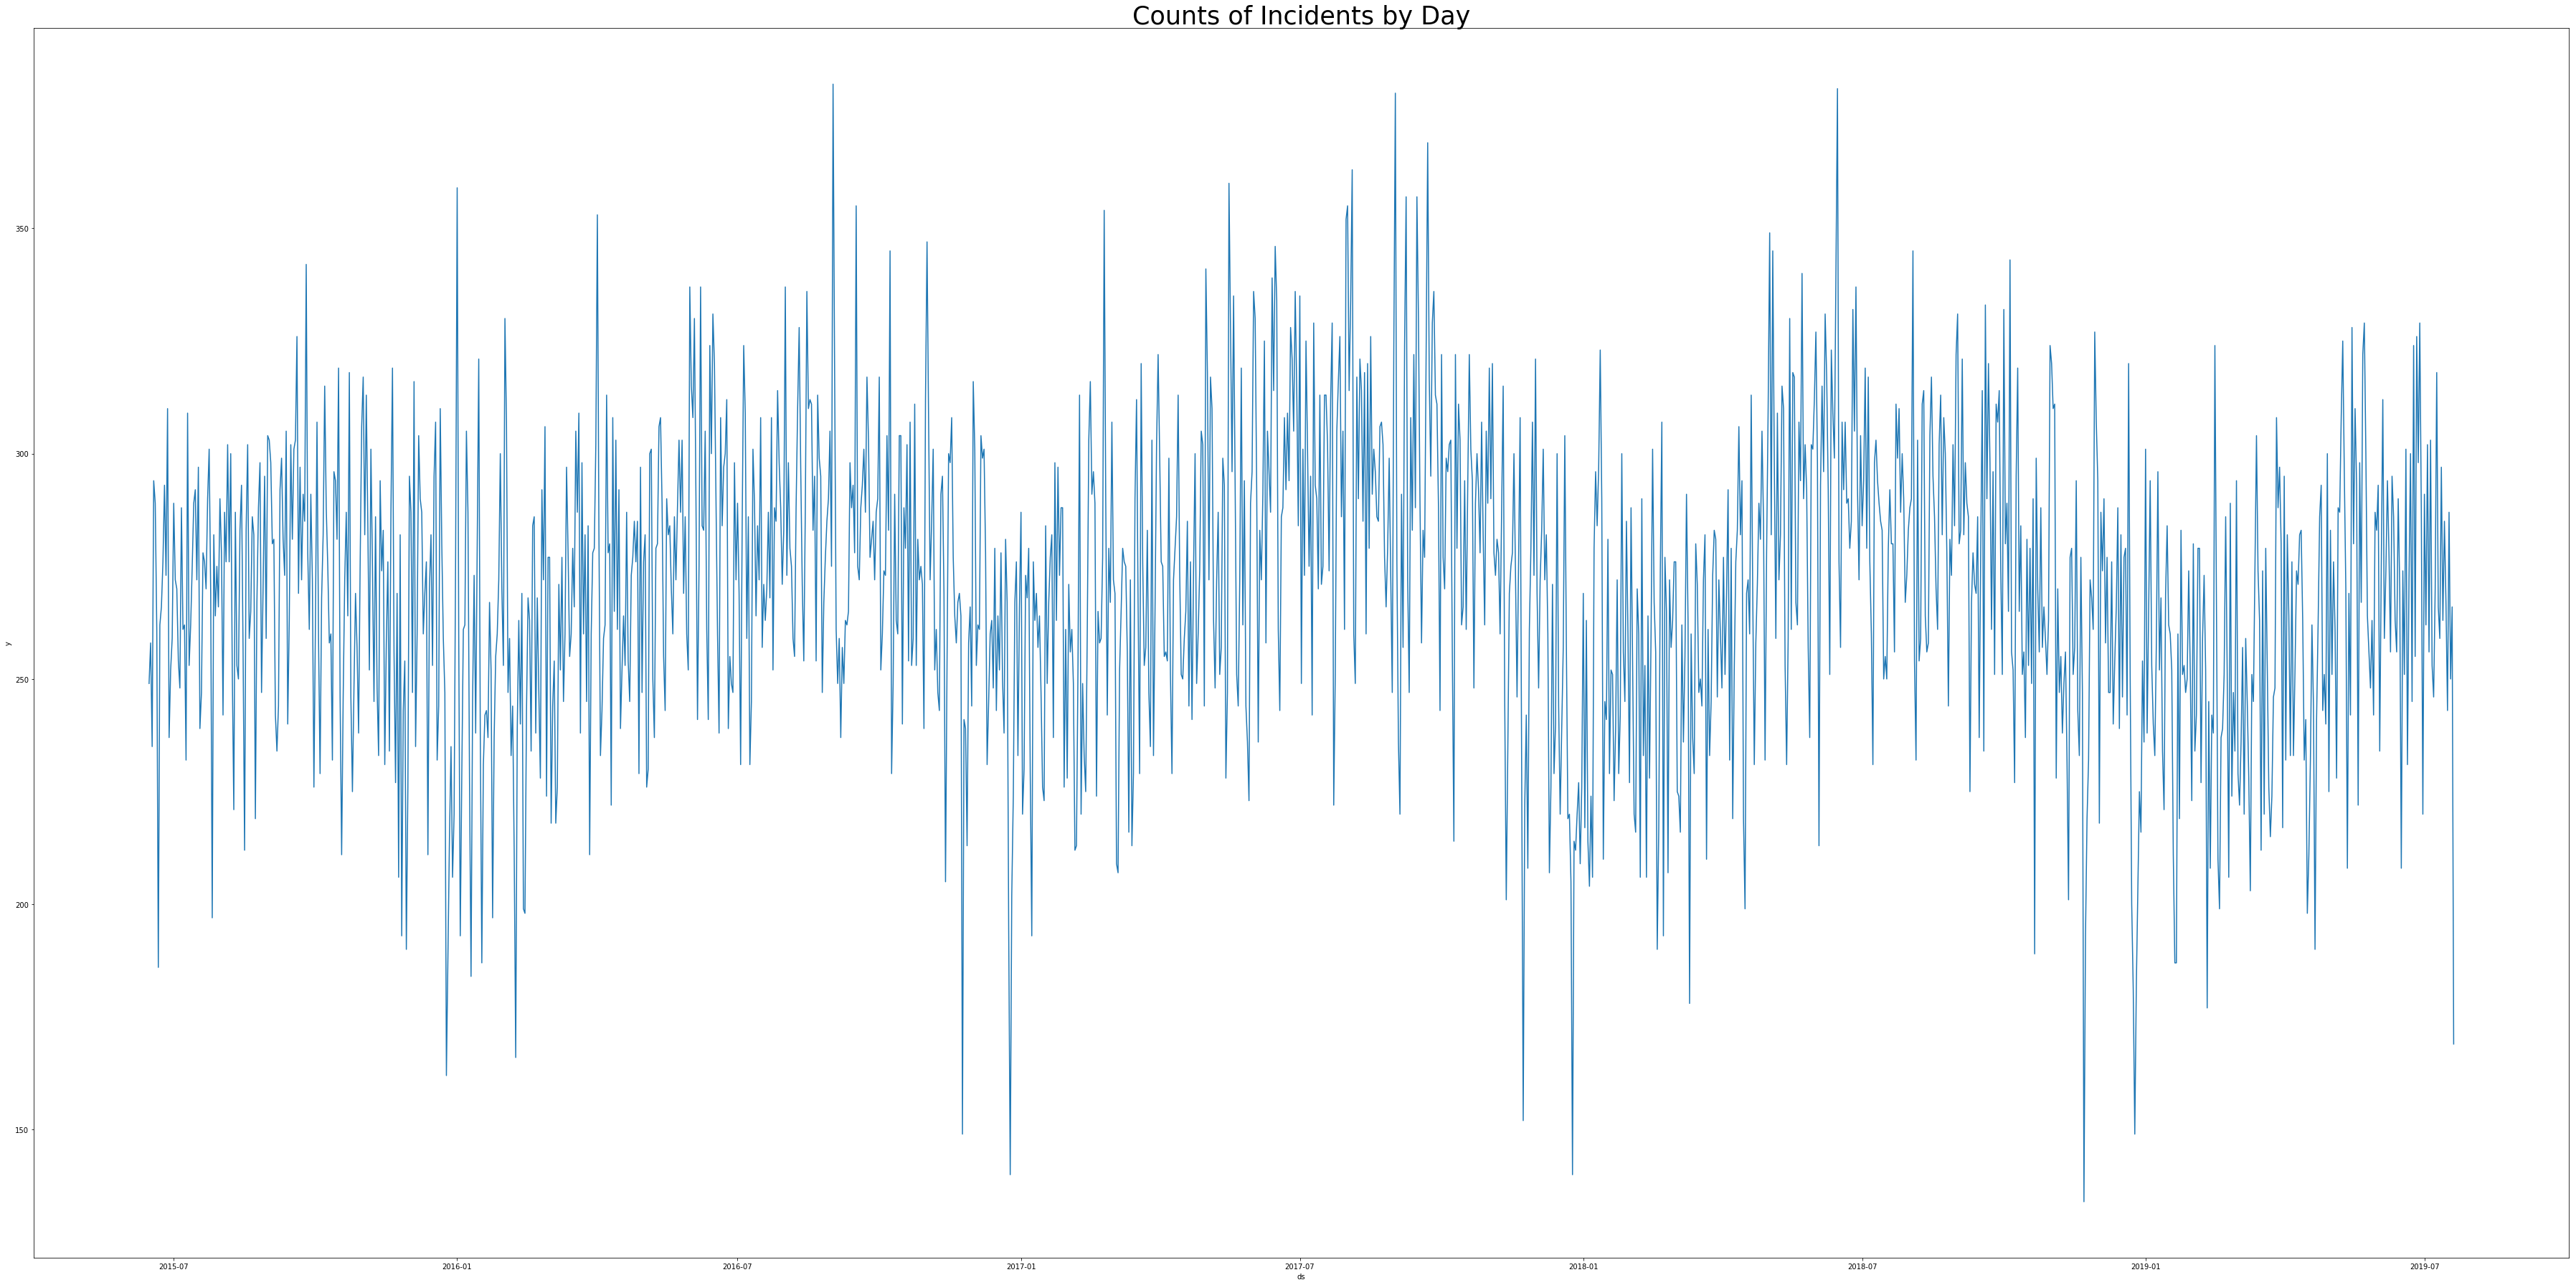

In [25]:
plt.figure(figsize=(50,25))
sns.lineplot(x='ds',y='y',data=dailydf)
plt.title('Counts of Incidents by Day',size=35)
plt.tight_layout()
plt.savefig('img/day_counts.png')

In [51]:
df.columns

Index(['INCIDENT_NUMBER', 'OFFENSE_CODE', 'OFFENSE_CODE_GROUP',
       'OFFENSE_DESCRIPTION', 'DISTRICT', 'REPORTING_AREA', 'SHOOTING',
       'OCCURRED_ON_DATE', 'YEAR', 'MONTH', 'DAY_OF_WEEK', 'HOUR', 'UCR_PART',
       'STREET', 'Lat', 'Long', 'Location', 'date', 'time'],
      dtype='object')

In [52]:
aggdf = df.set_index('date').groupby('date')[['INCIDENT_NUMBER']].count()

In [54]:
aggdf.reset_index(inplace=True)

In [56]:
aggdf.columns = ['date', 'count']

In [60]:
weeklydf = aggdf.set_index(pd.DatetimeIndex(aggdf['date']))

In [63]:
weeklydf = weeklydf.resample('W').apply(sum)

In [66]:
weeklydf.reset_index(inplace=True)

<Figure size 1080x360 with 0 Axes>

Text(0.5, 1.0, 'Counts of Incidents by Week')

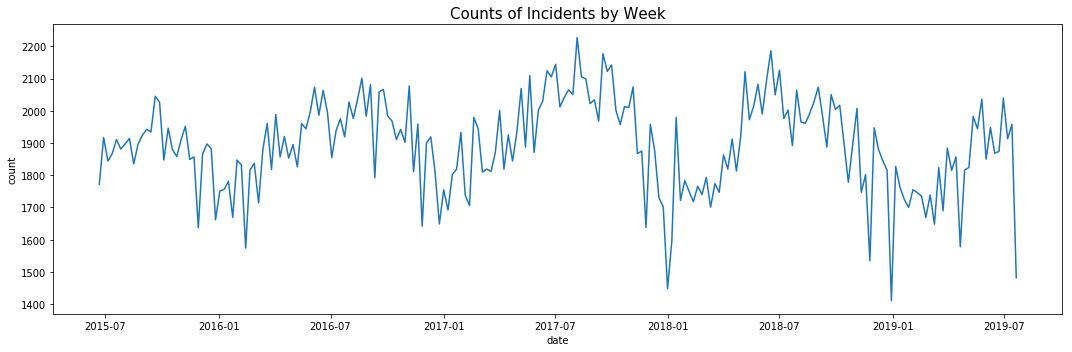

In [69]:
plt.figure(figsize=(15,5))
sns.lineplot(x='date',y='count',data=weeklydf)
plt.title('Counts of Incidents by Week',size=15)
plt.tight_layout()
plt.savefig('img/week_counts.png')

In [70]:
monthlydf = df.set_index(pd.DatetimeIndex(df['date']))
monthlydf = pd.DataFrame(monthlydf.resample('M').count())
monthlydf = monthlydf.drop(['date'], axis=1)
monthlydf.reset_index(inplace=True)
monthlydf = monthlydf[['date', 'INCIDENT_NUMBER']]
monthlydf.columns = ['month_of', 'count']
monthlydf.head()

,month_of,count
0,2015-06-30,4200
1,2015-07-31,8369
2,2015-08-31,8393
3,2015-09-30,8432
4,2015-10-31,8334


<Figure size 1080x360 with 0 Axes>

Text(0.5, 1.0, 'Counts of Incidents by Month')

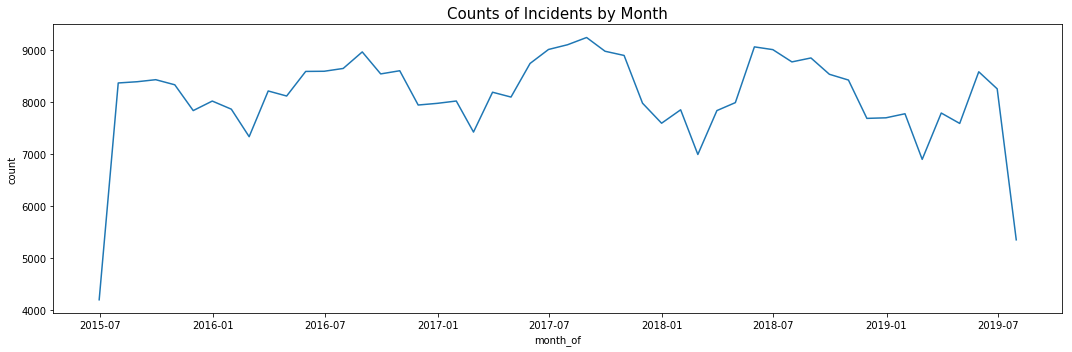

In [76]:
plt.figure(figsize=(15,5))
sns.lineplot(x='month_of',y='count',data=monthlydf)
plt.title('Counts of Incidents by Month',size=15)
plt.tight_layout()
plt.savefig('img/month_counts.png')

## Prophet Time Series Predictions

In [78]:
## ensure columns are named correctly for Prophet
dailydf.columns

Index(['ds', 'y'], dtype='object')

In [79]:
prediction_size = 365
train_df = dailydf[:-prediction_size]
train_df.tail(3)

,ds,y
1129,2018-07-18,279
1130,2018-07-19,292
1131,2018-07-20,280


In [80]:
m = Prophet()
m.fit(train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [81]:
future = m.make_future_dataframe(periods=prediction_size)
future.tail(3)

,ds
1494,2019-07-18
1495,2019-07-19
1496,2019-07-20


In [82]:
forecast = m.predict(future)
forecast.tail(3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1494,2019-07-18,269.547672,254.464200,317.875673,266.455695,272.425411,17.004634,17.004634,17.004634,6.563359,6.563359,6.563359,10.441275,10.441275,10.441275,0.0,0.0,0.0,286.552306
1495,2019-07-19,269.537676,263.528517,332.133181,266.432441,272.428434,28.200182,28.200182,28.200182,17.496190,17.496190,17.496190,10.703992,10.703992,10.703992,0.0,0.0,0.0,297.737857
1496,2019-07-20,269.527679,242.487629,309.913349,266.409188,272.431457,6.843233,6.843233,6.843233,-4.136412,-4.136412,-4.136412,10.979645,10.979645,10.979645,0.0,0.0,0.0,276.370912


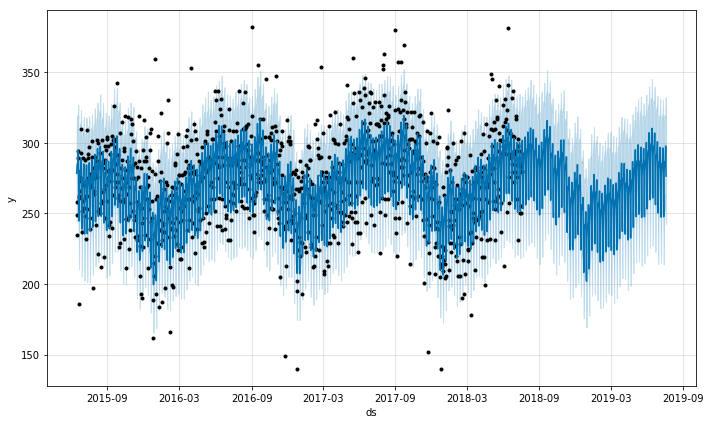

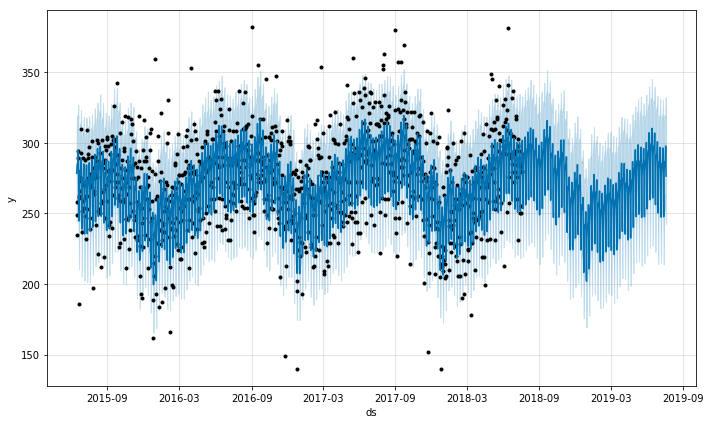

In [83]:
m.plot(forecast)

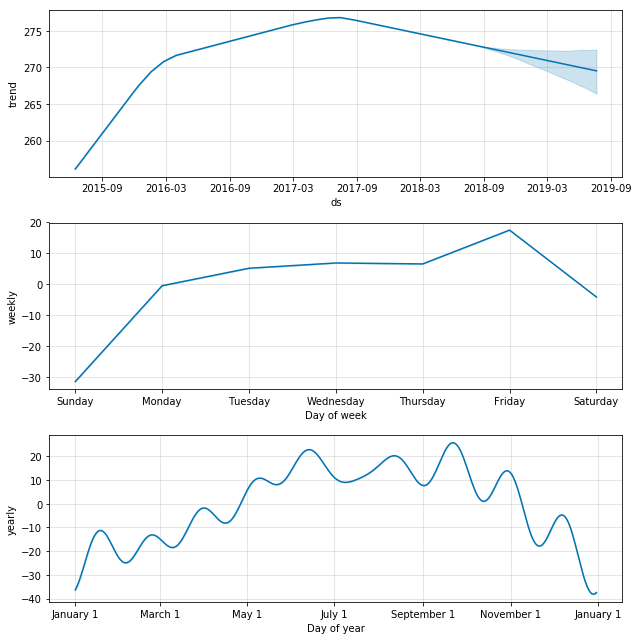

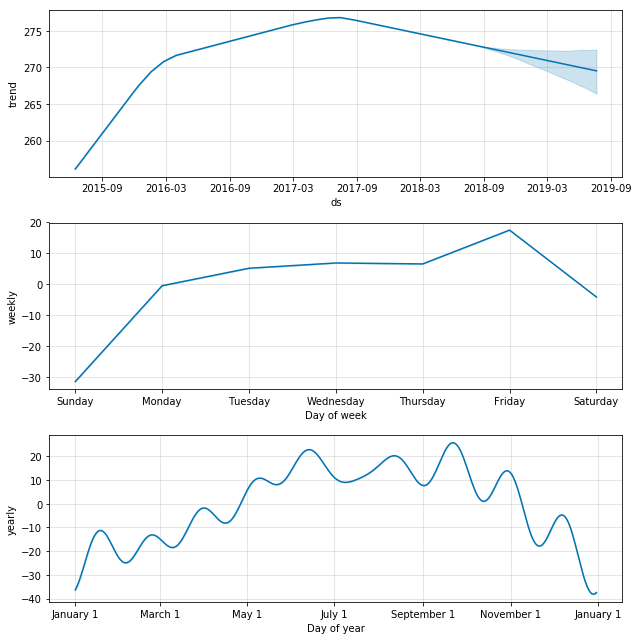

In [84]:
m.plot_components(forecast)

In [85]:
print(', '.join(forecast.columns))

ds, trend, yhat_lower, yhat_upper, trend_lower, trend_upper, additive_terms, additive_terms_lower, additive_terms_upper, weekly, weekly_lower, weekly_upper, yearly, yearly_lower, yearly_upper, multiplicative_terms, multiplicative_terms_lower, multiplicative_terms_upper, yhat


In [86]:
def make_comparison_dataframe(historical, forecast):
    '''
    join the history with the forecast.
    the resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper', and 'y'.
    '''
    return forecast.set_index('ds')[['yhat','yhat_lower','yhat_upper']].join(historical.set_index('ds'))

In [87]:
cmp_df = make_comparison_dataframe(dailydf,forecast)
cmp_df.head()

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2015-06-15,278.368462,244.453529,309.267788,249
2015-06-16,283.840522,252.112869,318.160224,258
2015-06-17,285.236710,253.197605,319.522565,235
2015-06-18,284.499306,251.283068,318.417950,294
2015-06-19,294.893654,260.172031,326.725539,289


In [88]:
def calculate_forecast_errors(df, prediction_size):
    '''Calculate MAPE and MAE of the forecast
    Input: df: joined dataset with 'y' and 'yhat' columns
    prediction_size: # days at the end to predict
    '''
    # make a copy
    df = df.copy()
    
    # calculate valuess of e_i and p_i according ot the formulas
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    # cut out prediction data
    predicted_part = df[-prediction_size:]
    
    # define function that averages absolute error values over predicted part
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    # calculate MAPE and MAE and return the resulting dictionary of errors
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [89]:
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
    print(err_name, err_value)

MAPE 8.790419759239148
MAE 21.644946662691257


In [90]:
cmp_df.head()

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2015-06-15,278.368462,244.453529,309.267788,249
2015-06-16,283.840522,252.112869,318.160224,258
2015-06-17,285.236710,253.197605,319.522565,235
2015-06-18,284.499306,251.283068,318.417950,294
2015-06-19,294.893654,260.172031,326.725539,289


In [92]:
cmp_df.reset_index(inplace=True)

<Figure size 2880x864 with 0 Axes>

Text(0.5, 1.0, 'Counts of Incidents by Day vs prediction')

Text(0, 0.5, 'count')

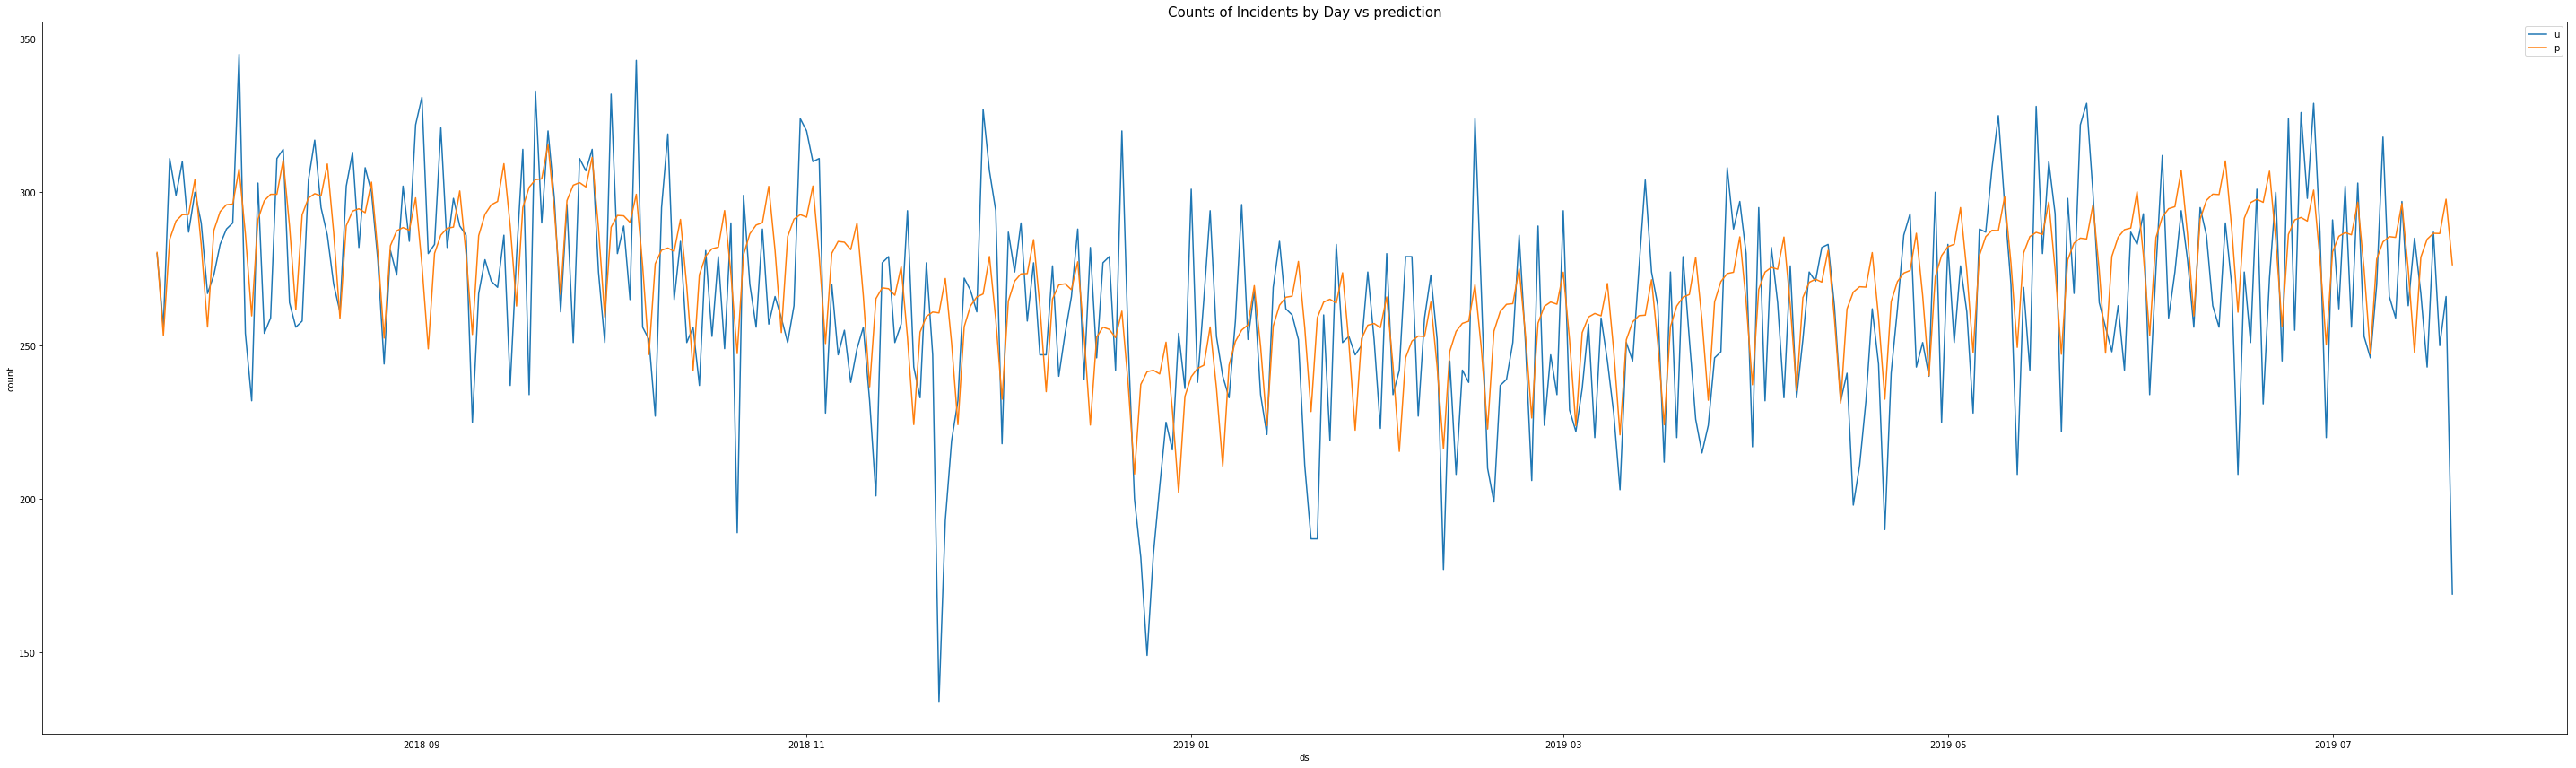

In [169]:
plt.figure(figsize=(40,12))
sns.lineplot(x='ds',y='y',data=cmp_df[-365:], label='actual')
sns.lineplot(x='ds', y='yhat', data=cmp_df[-prediction_size:], label='predicted')
plt.title('Counts of Incidents by Day vs prediction',size=15)
plt.ylabel('count')
plt.legend( 'upper right')
plt.tight_layout()
plt.savefig('img/act_pred.png')


<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Counts Actual vs. Predicted')

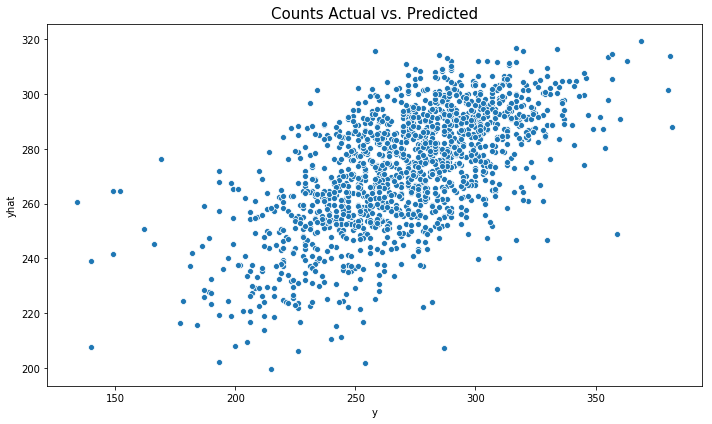

In [104]:
plt.figure(figsize=(10,6))
sns.scatterplot(cmp_df['y'],cmp_df['yhat'])
plt.title('Counts Actual vs. Predicted',size=15)
plt.tight_layout()
plt.savefig('img/act_pred2.png')

## Shooting Analysis and Modeling

In [106]:
dfshoot = df[df.SHOOTING == 'Y']
dfshoot.DISTRICT.value_counts()

B2     588
B3     366
C11    271
D4     103
E13    101
E18     53
C6      53
A7      33
D14     29
E5      26
A1      21
A15      7
Name: DISTRICT, dtype: int64

In [127]:
dfshoot.head(3)

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location,date,time
908,I192055085,3001,Medical Assistance,DEATH INVESTIGATION,E5,561,Y,2019-07-17 15:10:00,2019,Jul,Wednesday,15,Part Three,ROWE ST,42.283360,-71.120424,"(42.28336048, -71.12042417)",2019-07-17,15:10:00
1066,I192054903,413,Aggravated Assault,ASSAULT - AGGRAVATED - BATTERY,B2,306,Y,2019-07-17 00:03:00,2019,Jul,Wednesday,0,Part One,CODMAN PARK,42.319047,-71.094000,"(42.31904705, -71.09399992)",2019-07-17,00:03:00
1067,I192054903,3119,Firearm Discovery,FIREARM/WEAPON - FOUND OR CONFISCATED,B2,306,Y,2019-07-17 00:03:00,2019,Jul,Wednesday,0,Part Three,CODMAN PARK,42.319047,-71.094000,"(42.31904705, -71.09399992)",2019-07-17,00:03:00


In [130]:
dailyshoot = dfshoot[['date', 'INCIDENT_NUMBER']].groupby('date').count()
dailyshoot.reset_index(inplace=True)
dailyshoot.columns = ['ds', 'y']

In [131]:
dailyshoot.head(5)

,ds,y
0,2015-06-16,3
1,2015-06-19,1
2,2015-06-20,5
3,2015-06-24,1
4,2015-06-25,1


In [140]:
dailyshoot[dailyshoot.y == max(dailyshoot.y)]

,ds,y
381,2017-12-20,28


<Figure size 792x432 with 0 Axes>

Text(0.5, 1.0, 'Counts of Incidents by Day')

Text(0.5, 0, 'date')

Text(0, 0.5, 'count')

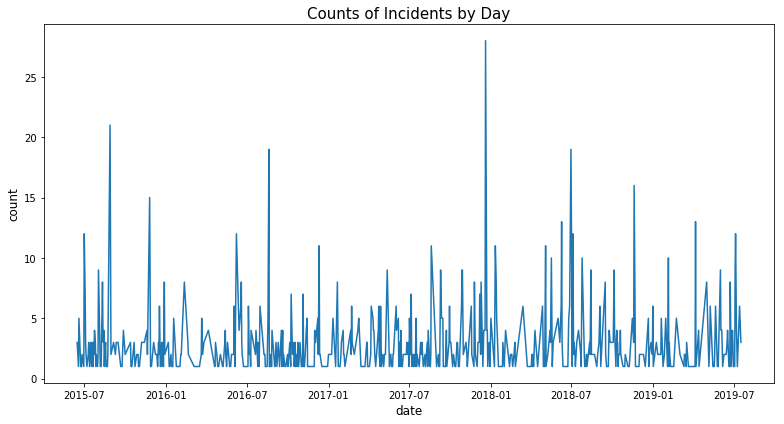

In [136]:
plt.figure(figsize=(11,6))
sns.lineplot(x='ds',y='y',data=dailyshoot)
plt.title('Counts of Incidents by Day',size=15)
plt.xlabel('date', size=12)
plt.ylabel('count', size=12)
plt.tight_layout()

In [145]:
weeklyshoot = dfshoot.set_index(pd.DatetimeIndex(dfshoot['date']))
weeklyshoot = pd.DataFrame(weeklyshoot.resample('W').count())
weeklyshoot = weeklyshoot.drop(['date'], axis=1)
weeklyshoot.reset_index(inplace=True)
weeklyshoot = weeklyshoot[['date', 'INCIDENT_NUMBER']]
weeklyshoot.columns = ['ds', 'y']
weeklyshoot.head()

,ds,y
0,2015-06-21,9
1,2015-06-28,5
2,2015-07-05,23
3,2015-07-12,8
4,2015-07-19,9


<Figure size 792x432 with 0 Axes>

Text(0.5, 1.0, 'Counts of Shootings by Week')

Text(0.5, 0, 'date')

Text(0, 0.5, 'count')

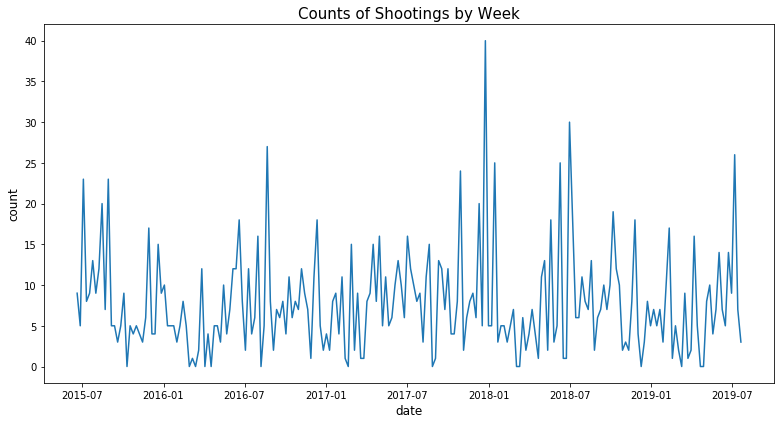

In [147]:
plt.figure(figsize=(11,6))
sns.lineplot(x='ds',y='y',data=weeklyshoot)
plt.title('Counts of Shootings by Week',size=15)
plt.xlabel('date', size=12)
plt.ylabel('count', size=12)
plt.tight_layout()

In [153]:
logging.getLogger().setLevel(logging.ERROR)

In [151]:
shoot_pred_size = 100
train_df_shoot = dailyshoot[:-shoot_pred_size]
train_df_shoot.tail(3)

,ds,y
479,2018-09-23,3
480,2018-09-24,4
481,2018-09-26,3


In [154]:
m1 = Prophet()
m1.fit(train_df_shoot);

In [155]:
future1 = m1.make_future_dataframe(periods=shoot_pred_size)

In [156]:
future1.tail()

,ds
577,2018-12-31
578,2019-01-01
579,2019-01-02
580,2019-01-03
581,2019-01-04


In [157]:
forecast1 = m1.predict(future1)
forecast1.tail(3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
579,2019-01-02,3.333933,0.061405,7.484937,3.332416,3.335527,0.567664,0.567664,0.567664,0.243223,0.243223,0.243223,0.324442,0.324442,0.324442,0.0,0.0,0.0,3.901598
580,2019-01-03,3.334836,0.053562,7.119555,3.333291,3.336452,0.374056,0.374056,0.374056,0.086456,0.086456,0.086456,0.287600,0.287600,0.287600,0.0,0.0,0.0,3.708892
581,2019-01-04,3.335739,0.086719,7.166537,3.334172,3.337370,0.203509,0.203509,0.203509,-0.049932,-0.049932,-0.049932,0.253441,0.253441,0.253441,0.0,0.0,0.0,3.539248


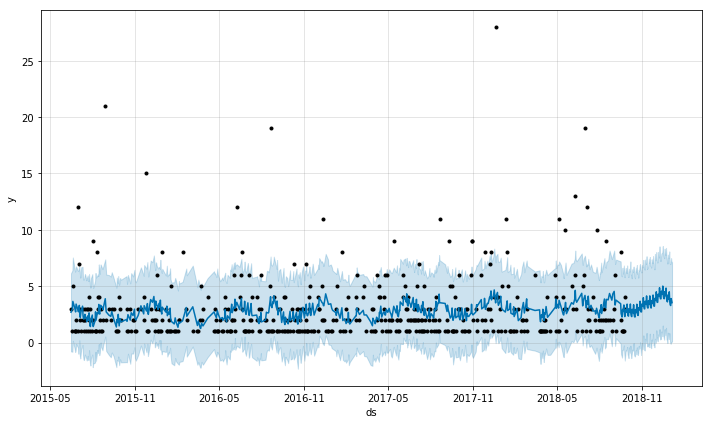

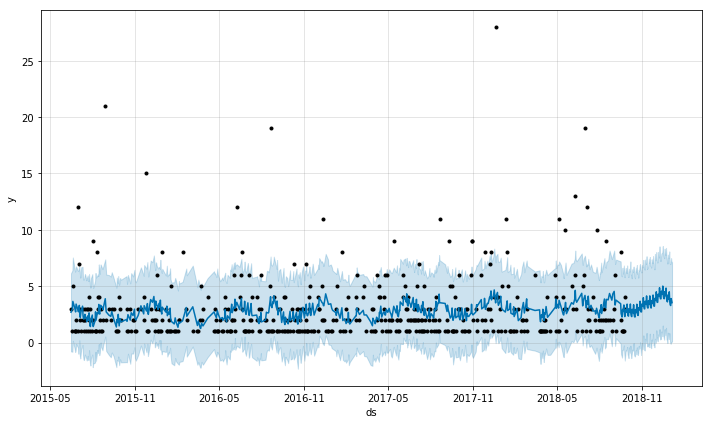

In [158]:
m1.plot(forecast1)

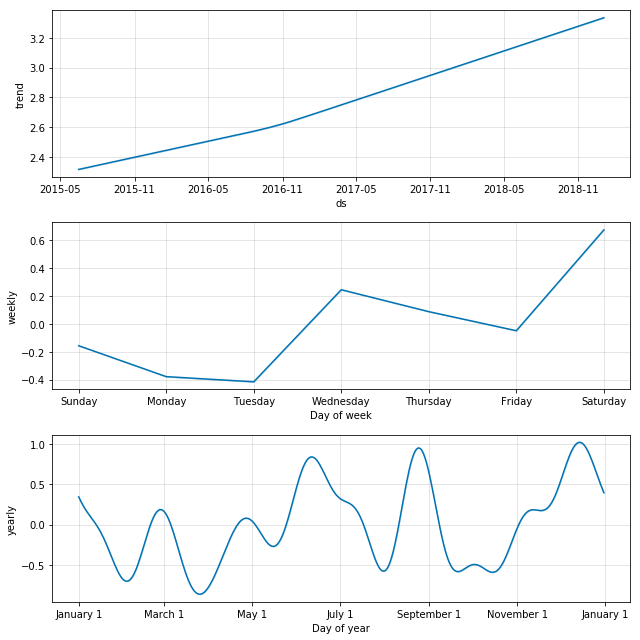

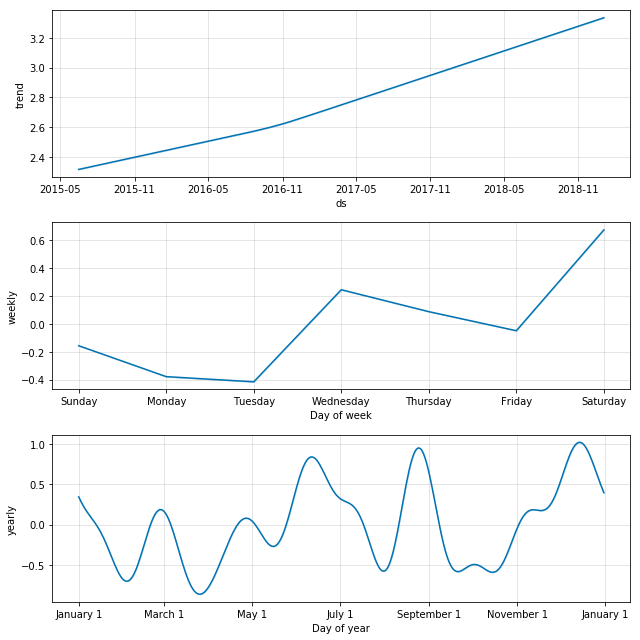

In [159]:
m1.plot_components(forecast1)

In [160]:
print(', '.join(forecast1.columns))

ds, trend, yhat_lower, yhat_upper, trend_lower, trend_upper, additive_terms, additive_terms_lower, additive_terms_upper, weekly, weekly_lower, weekly_upper, yearly, yearly_lower, yearly_upper, multiplicative_terms, multiplicative_terms_lower, multiplicative_terms_upper, yhat


In [161]:
cmp_df1 = make_comparison_dataframe(dailyshoot,forecast1)

In [162]:
cmp_df1.head(3)

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2015-06-16,2.687189,-0.792056,6.144505,3.0
2015-06-19,2.963083,-0.817336,6.391499,1.0
2015-06-20,3.648679,0.154174,7.548656,5.0


In [164]:
for err_name, err_value in calculate_forecast_errors(cmp_df1, shoot_pred_size).items():
    print(err_name, err_value)

MAPE 117.80055967434869
MAE 2.0315618046627897


In [165]:
cmp_df1.reset_index(inplace=True)

In [166]:
cmp_df1.shape

(582, 5)

<Figure size 1152x864 with 0 Axes>

Text(0.5, 1.0, 'Counts of Incidents by Day vs prediction')

Text(0, 0.5, 'count')

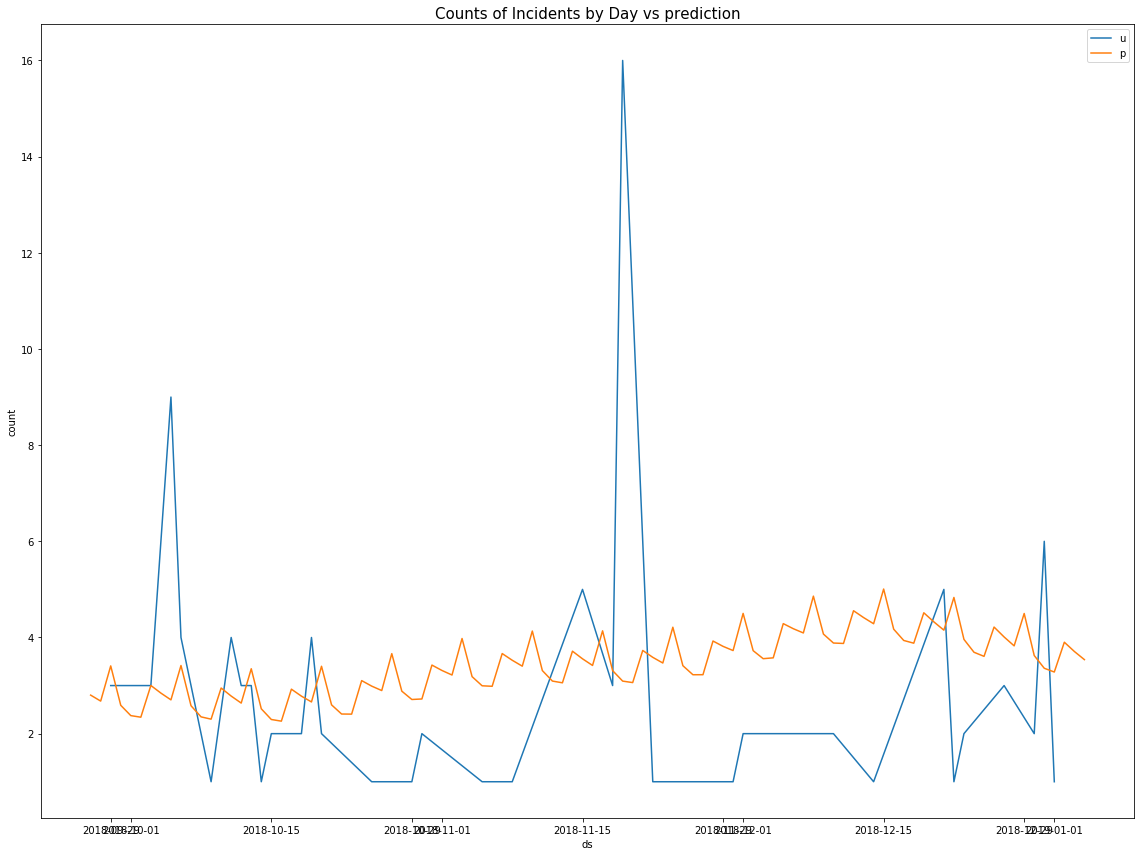

In [168]:
labels = ['actual', 'predicted']
plt.figure(figsize=(16,12))
sns.lineplot(x='ds',y='y',data=cmp_df1[-shoot_pred_size:], label='actual')
sns.lineplot(x='ds', y='yhat', data=cmp_df1[-shoot_pred_size:], label='predicted')
plt.title('Counts of Incidents by Day vs prediction',size=15)
plt.ylabel('count')
plt.legend( 'upper right')
plt.tight_layout()
# plt.savefig('img/act_pred.png')


<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Counts Actual vs. Predicted')

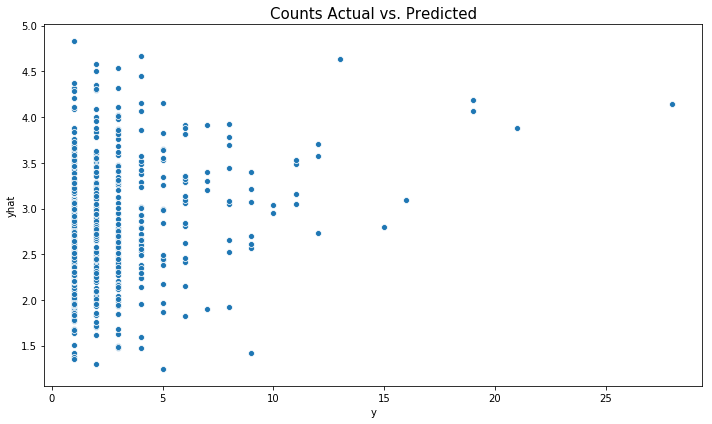

In [170]:
plt.figure(figsize=(10,6))
sns.scatterplot(cmp_df1['y'],cmp_df1['yhat'])
plt.title('Counts Actual vs. Predicted',size=15)
plt.tight_layout()
# plt.savefig('img/act_pred2.png')

In [ ]:
# waffledistrict
fig = plt.figure(
    FigureClass=Waffle,
    rows=12,
    values= list(waffle['count']),
    labels= list(waffle['district']))